In [754]:
# import necessary packaages
import numpy as np
import pandas as pd
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import folium
import contextily as cx
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [526]:
# define functions
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.map(trim_strings)

def read_clean_data(file_name):
    """
    Imports datasets that have semicolon separators for some reason and also weird characters
    """
    df = pd.read_csv(file_name, sep = ';', on_bad_lines='warn')
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace('\ufeff', '')
    df = trim_all_columns(df)
    return df

def create_map(base_df, analysis_df, base_unit, analysis_unit, geo_frame, quotient = 1, year = 2023):
    """
    Creates a chloropleth map given a base map at neighborhood level (i.e. households or population) 
    and geographic analysis dataset at sub-neighborhood level (points, lines, or polygons)
    """
    # create a base map at the neighborhood level
    base = base_df.reset_index().dissolve('cod_zona')
    # add the points of analysis to the neighborhood base map
    base_w_analysis = base.join(analysis_df)
    # aggregate the points of analysis per the base unit
    base_w_analysis[str(analysis_unit + "_per_" + str(quotient) + "_" + base_unit)] = base_w_analysis[str(analysis_unit + "_count")]/(base_w_analysis[str(year)] / quotient)
    # round the result to 4 decimal places
    base_w_analysis = base_w_analysis.round(4)
    # create an interactive chlorpleth of this data
    chloropleth = base_w_analysis.explore(column = str(analysis_unit + "_per_" + str(quotient) + "_" + base_unit), cmap = 'RdBu_r', tooltip = ('zona', str(year), str(analysis_unit + "_count"), str(analysis_unit + "_per_" + str(quotient) + "_" + base_unit)), 
                                          tiles = 'CartoDB positron', legend=True)
    # call explore function
    return geo_frame.explore(m = chloropleth)

def create_geo_df(df):
    """
    Takes a df of a certain format and transforms it into a geopandas compatible data frame
    """
    df[['y','x']] = df['Geo Point'].str.split(', ', expand = True)
    df_geo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y), crs="EPSG:4326")
    return df_geo

In [746]:
# import base data sets

    # import geojson of base map of statistical areas
base_map_data = gpd.read_file("./Data/aree-statistiche.geojson")
# convert CRS to equal area
base_map_data = base_map_data.to_crs(epsg=6933)
# rename zones for consistency
base_map_data.loc[base_map_data.zona == 'S. Viola', 'zona'] = 'Santa Viola'
base_map_data.loc[base_map_data.zona == 'S. Vitale', 'zona'] = 'San Vitale'
base_map_data.loc[base_map_data.zona == 'S. Ruffillo', 'zona'] = 'San Ruffillo'
# create a map at the zone level
base_map_zone = base_map_data.dissolve('zona')[['geometry','cod_zona']]


    # import population data
population = read_clean_data("./Data/popolazione-residente-per-eta-sesso-cittadinanza-quartiere-zona-area-statistica-.csv")
# cast the year column as a string for future processing
population['Anno'] = population['Anno'].astype(str)
    # clean and combine the dataset with the base map
# aggregate population at the zone level
pop_agg = population.groupby(['Anno', 'Zona'])['Residenti'].sum().to_frame().pivot_table('Residenti', ['Zona'], 'Anno')
# get 2019 data
pop_2019 = pop_agg[['2019']].rename(columns={'2019':'population'})
# join the base map data with the population data
base_map_2019 = base_map_zone.join(pop_2019)

    # import household data
# number of resident households / families per neighborhood
households = read_clean_data("./Data/famiglie-residenti-per-quartiere-zona-area-statistica-e-ampiezza-della-famiglia-.csv")
# cast the year column as a string for future processing
households['Anno'] = households['Anno'].astype(str)
    # clean and combine the dataset with the base map
# aggregate the household count at the zone level
households_agg = households.groupby(['Anno', 'Zona'])['Numero Famiglie'].sum().to_frame().pivot_table('Numero Famiglie', ['Zona'], 'Anno')
# get 2019 data
hh_2019 = households_agg[['2019']].rename(columns={'2019':'households'})
# create a base map with number of households to explore in comparison to per capita
base_map_2019 = base_map_2019.join(hh_2019)

    # import income data
income = read_clean_data("./Data/redditi-per-area-statistica.csv")
# format the year field
income['Anno reddito'] = income['Anno reddito'].astype(str)
income = income.rename(columns={'Anno reddito':'anno'})
# pivot the income to have each year be a column
#income = income.pivot_table(values = ['Reddito medio contribuente','N contribuenti'], index = ['Area Statistica'], columns = ['anno'])
# get most recent data
income_2019 = income.loc[income['anno'] == '2019']
# join with zones and aggregate at zone level
# value needs to be capitalized for matching 
income_2019['Area Statistica'] = income_2019['Area Statistica'].str.upper()
# rename and filter to relevant columns
income_2019 = income_2019.rename(columns={'Area Statistica':'area_statistica','N contribuenti':'n_taxpayers','Reddito imponibile ai fini irpef':'total_income'})[['area_statistica','n_taxpayers','total_income']]
# aggregate at the statistical area level
income_2019_agg = income_2019.groupby(['area_statistica'])[['n_taxpayers','total_income']].sum()
# join the base map data and aggregate income data at the zone level 
income_zone = income_2019_agg.join(base_map_data.reset_index().set_index('area_statistica')).groupby(['zona'])[['n_taxpayers','total_income']].sum()
income_zone['avg_income'] = round(income_zone['total_income'] / income_zone['n_taxpayers'],0)
# append income info to 2019 base map
base_map_2019 = base_map_2019.join(income_zone[['n_taxpayers','avg_income']])
# calculate taxpayers per capita
base_map_2019['taxpayers_per_cap'] = round(base_map_2019['n_taxpayers'] / base_map_2019['population'],4)
    
    # import employment and student data
occupation = read_clean_data("./Data/occupati_statistica.csv")
# format the year field
occupation['Anno di riferimento'] = occupation['Anno di riferimento'].astype(str)
occupation = occupation.rename(columns={'Anno di riferimento':'anno', 'Nome zona':'zona','Sezione censimento (2011)':'census_tract','Numero unità locali':'n_local_units','Numero addetti (dipendenti e indipendenti)':'n_workers','Numero addetti istituzioni pubbliche':'n_public_workers','Numero studenti':'n_students'})
# format the zona field
occupation.loc[occupation.zona == 'S. Viola', 'zona'] = 'Santa Viola'
occupation.loc[occupation.zona == 'S. Vitale', 'zona'] = 'San Vitale'
occupation.loc[occupation.zona == 'S. Ruffillo', 'zona'] = 'San Ruffillo'
# get only the latest data
occupation_2019 = occupation.loc[occupation['anno'] == '2019']
# aggregate the stats at the zona level
occupation_2019_agg = occupation_2019.groupby(['zona'])[['n_workers','n_students']].sum()
# append occupation info to the base map
base_map_2019 = base_map_2019.join(occupation_2019_agg) # *** number of workers seems a bit off - ask marco about it
# calculate workers and students per capita
base_map_2019['workers_per_cap'] = round(base_map_2019['n_workers'] / base_map_2019['population'],4)
base_map_2019['students_per_cap'] = round(base_map_2019['n_students'] / base_map_2019['population'],4)

    # calculate additional summary stats
# density
base_map_2019['pop_density_km2'] = round(base_map_2019['population'] / (base_map_2019.area/1000000), 0)
# avg people per household
base_map_2019['avg_household_size'] = round(base_map_2019['population'] / base_map_2019['households'], 2)

# scratchpad to view data
base_map_2019

/var/folders/h0/v7zgqxss2wd19s_7gjwcb35r0000gn/T/ipykernel_97071/2231063367.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_2019['Area Statistica'] = income_2019['Area Statistica'].str.upper()


geometry cod_zona  \
zona                                                                          
Barca            POLYGON ((1090863.898 5134599.020, 1090897.505...        A   
Bolognina        POLYGON ((1095745.882 5135403.240, 1095738.186...        B   
Borgo Panigale   POLYGON ((1089322.227 5134968.873, 1089311.237...        C   
Colli            POLYGON ((1095313.116 5132678.853, 1095330.743...        D   
Corticella       POLYGON ((1095936.171 5136829.319, 1095934.779...        E   
Costa Saragozza  POLYGON ((1092211.245 5132467.049, 1092206.791...        F   
Galvani          POLYGON ((1095316.775 5133775.949, 1095379.646...        G   
Irnerio          POLYGON ((1095248.043 5133799.724, 1095224.424...        H   
Lame             POLYGON ((1093948.003 5136890.582, 1093943.073...        I   
Malpighi         POLYGON ((1094320.882 5133697.008, 1094311.370...        L   
Marconi          POLYGON ((1094502.233 5134360.132, 1094478.095...        M   
Mazzini          POLYGON ((1099555.583 5131464.123, 1099598.650...        N   
Murri            POLYGON ((1097674.583 5132304.411, 1097675.047...        O   
Saffi            POLYGON ((1092881.434 5134435.320, 1092881.049...        P   
San Donato       POLYGON ((1097569.457 5134586.171, 1097558.967...        Q   
San Ruffillo     POLYGON ((1097303.980 5130125.817, 1097304.883...        R   
San Vitale       POLYGON ((1101474.382 5133009.811, 1101459.299...        T   
Santa Viola      POLYGON ((1091186.599 5135000.488, 1091161.180...        S   

                 population  households  n_taxpayers  avg_income  \
zona                                                               
Barca               21097.0     10478.0        15838     22480.0   
Bolognina           36388.0     19343.0        25915     21062.0   
Borgo Panigale      26764.0     13301.0        19850     22023.0   
Colli                8836.0      4198.0         5901     46052.0   
Corticella          18594.0      8982.0        13917     23347.0   
Costa Saragozza     24757.0     13492.0        18596     31058.0   
Galvani             13109.0      7605.0         9482     39098.0   
Irnerio             13751.0      8704.0        10090     33093.0   
Lame                14543.0      7176.0        10687     22188.0   
Malpighi            11941.0      7177.0         8870     31953.0   
Marconi             14658.0      8820.0        11097     32556.0   
Mazzini             38571.0     19873.0        29303     24233.0   
Murri               28814.0     15422.0        21409     32750.0   
Saffi               18239.0     10333.0        13814     24210.0   
San Donato          31527.0     16632.0        22798     20666.0   
San Ruffillo        21571.0     11047.0        16124     25950.0   
San Vitale          34793.0     19011.0        25380     24913.0   
Santa Viola         13498.0      7101.0         9844     23785.0   

                 taxpayers_per_cap  n_workers  n_students  workers_per_cap  \
zona                                                                         
Barca                       0.7507       5055      3160.0           0.2396   
Bolognina                   0.7122      11247      7424.0           0.3091   
Borgo Panigale              0.7417      14442      2260.0           0.5396   
Colli                       0.6678       2490       658.0           0.2818   
Corticella                  0.7485      10077      2083.0           0.5419   
Costa Saragozza             0.7511       4468      1891.0           0.1805   
Galvani                     0.7233       9502      3244.0           0.7248   
Irnerio                     0.7338      11894      1470.0           0.8650   
Lame                        0.7349       7795      2319.0           0.5360   
Malpighi                    0.7428       7732      6258.0           0.6475   
Marconi                     0.7571      14658      2734.0           1.0000   
Mazzini                     0.7597       5567      4333.0           0.1443   
Murri                   

In [463]:
# HOUSEHOLDS PER CAPITA
   
    # investigating how population and households compare in 2023
# join the population base map with the household aggregated data
pop_vs_household_2023 = base_map_w_pop.join(households_agg[['2023']].rename(columns={'2023':'household_count'})['household_count'].to_frame())

# dissolve the result from the previous line to the zone level
pop_vs_household_2023_zona = pop_vs_household_2023.dissolve(pop_vs_household_2023.index)

# calculate households per capita based off of 2023 metrics
pop_vs_household_2023_zona['household_per_cap_2023'] = pop_vs_household_2023_zona['household_count']/pop_vs_household_2023_zona['2023']

# map the households per capita in the same fashion as the other maps
# red means more households compared to people, i.e. more households are made up of fewer people
# TODO : can't use the mapping function since these are both zone-level geometries and there are no points - is there a way to change the function to make it more dynamic?
    # maybe an if/else switch thing using a new string argument that passes the geometry type
pop_vs_household_2023_zona.explore(column = 'household_per_cap_2023', cmap = 'RdBu_r', tooltip = ('zona', '2023', 'household_count', 'household_per_cap_2023'), 
                                          tiles = 'CartoDB positron', legend=True)

In [460]:
# HOUSEHOLD SECURITY #

# 1. airbnb #

    # import airbnb data
# number of airbnbs from airbnb survey
#airbnb = pd.read_csv("./Data/bologna-rilevazione-airbnb.csv", on_bad_lines='warn')

    # process the data set in prepartion for mapping
# extract the latitude and longitude of each airbnb
airbnb[['lat','long']] = airbnb['Coordinate'].str.split(',',expand=True)
# turn the airbnb data into a geo data frame
airbnb_geo = gpd.GeoDataFrame(
    airbnb, geometry=gpd.points_from_xy(airbnb.long, airbnb.lat), crs="EPSG:4326"
)
# aggregate the count of wifi hotspots at the neighborhood level
airbnb_agg = gpd.overlay(base_map_w_pop, airbnb_geo, how='intersection', keep_geom_type=False).groupby('cod_zona').count()
# rename and subset the data just to the count of the hotspots per neighborhood
airbnb_agg = airbnb_agg.rename(columns={'id':'airbnb_count'})['airbnb_count'].to_frame()

create_map(base_map_w_households, airbnb_agg, 'household', 'airbnb', airbnb_geo)

# 2. #

In [461]:
# WIFI #

    # import wifi data
# wifi connection point locations
#wifi = pd.read_csv("./Data/bolognawifi-elenco-hot-spot.csv", on_bad_lines='warn')
# number of wifi connections per neighborhood
connections = read_clean_data("./Data/bolognawifi-connessioni-giornaliere.csv")

    # process the data for mapping
# turn the wifi data into a geo data frame
wifi_geo = gpd.GeoDataFrame(
    wifi, geometry=gpd.points_from_xy(wifi.x, wifi.y), crs="EPSG:4326"
)
# aggregate the count of wifi hotspots at the neighborhood level
wifi_agg = gpd.overlay(base_map_w_pop, wifi_geo, how='intersection', keep_geom_type=False).groupby('cod_zona').count()
# rename and subset the data just to the count of the hotspots per neighborhood
wifi_agg = wifi_agg.rename(columns={'Hostname':'hotspot_count'})['hotspot_count']

# map the wifi per capita
create_map(base_map_w_pop, wifi_agg, 'population', 'hotspot', wifi_geo, quotient = 1000)

In [462]:
# PARTICIPATORY BUDGET #

    # import civic participation data
#participative_budget = read_clean_data("./Data/bilancio-partecipativo.csv")

    # process data for mapping
# turn the data into a geo data frame
participative_budget[['y','x']] = participative_budget['Geo Point'].str.split(', ', expand = True)
budg_geo = gpd.GeoDataFrame(
    participative_budget, geometry=gpd.points_from_xy(participative_budget.x, participative_budget.y), crs="EPSG:4326"
)
# aggregate the count of participative budget projects at the neighborhood level
budg_agg = gpd.overlay(base_map_w_pop, budg_geo, how='intersection', keep_geom_type=False).groupby('cod_zona').count()
# rename and subset the data just to the count of the projects per neighborhood
budg_agg = budg_agg.rename(columns={'Progetto':'project_count'})['project_count']

    # map the data
create_map(base_map_w_pop, budg_agg, 'population', 'project', budg_geo, quotient = 1000)

In [732]:
# STREET FURNITURE #

    # import the street furniture dataset
#furniture = read_clean_data("./Data/arredo.csv")
   
    # create a geo df of the street furniture
furniture_geo = create_geo_df(furniture)
furniture_geo

#furniture_geo.explore(column = 'Stato di conservazione')

Geo Point  \
0      44.469407662604745, 11.379755725067746   
1       44.46937271252582, 11.379918557289146   
2       44.512052472483546, 11.28940853046326   
3       44.46855057117028, 11.380046409226463   
4        44.4685353949516, 11.379992071388447   
...                                       ...   
14128   44.49726155580926, 11.365849208212046   
14129    44.49716364285431, 11.36579171578488   
14130    44.49399434692183, 11.36162809735666   
14131   44.50251582168404, 11.333257482111863   
14132   44.50247338923189, 11.333128111435288   

                                               Geo Shape  \
0      {"coordinates": [11.379755725067746, 44.469407...   
1      {"coordinates": [11.379918557289146, 44.469372...   
2      {"coordinates": [11.28940853046326, 44.5120524...   
3      {"coordinates": [11.380046409226463, 44.468550...   
4      {"coordinates": [11.379992071388447, 44.468535...   
...                                                  ...   
14128  {"coordinates": [11.365849208212046, 44.497261...   
14129  {"coordinates": [11.36579171578488, 44.4971636...   
14130  {"coordinates": [11.36162809735666, 44.4939943...   
14131  {"coordinates": [11.333257482111863, 44.502515...   
14132  {"coordinates": [11.333128111435288, 44.502473...   

                    Tipo di arredo Data Aggiornamento  \
0      Panchina in legno e metallo         2005-09-13   
1      Panchina in legno e metallo         2005-09-13   
2           Panchine di altro tipo         2005-10-16   
3      Panchina in legno e metallo         2005-09-14   
4      Panchina in legno e metallo         2005-09-14   
...                            ...                ...   
14128  Panchina in legno e metallo         2022-08-10   
14129  Panchina in legno e metallo         2022-08-10   
14130  Panchina in legno e metallo         2006-06-22   
14131           Cestino in metallo         2006-05-09   
14132           Cestino in metallo         2006-05-09   

                     quartiere     area statistica  \
0                       Savena             CORELLI   
1                       Savena             CORELLI   
2        Borgo Panigale - Reno  TRIUMVIRATO-PIETRA   
3                       Savena             CORELLI   
4                       Savena             CORELLI   
...                        ...                 ...   
14128  San Donato - San Vitale           CIRENAICA   
14129  San Donato - San Vitale           CIRENAICA   
14130  San Donato - San Vitale           CIRENAICA   
14131        Porto - Saragozza           MARCONI-2   
14132        Porto - Saragozza           MARCONI-2   

                            zona prossimita Stato di conservazione  \
0                              LUNGO SAVENA               DISCRETO   
1                              LUNGO SAVENA                  BUONO   
2                 CASTELDEBOLE - PONTELUNGO               SCADENTE   
3                              LUNGO SAVENA               DISCRETO   
4                              LUNGO SAVENA               DISCRETO   
...                                     ...                    ...   
14128  CIRENAICA - MASSARENTI - SCANDELLARA                  BUONO   
14129  CIRENAICA - MASSARENTI - SCANDELLARA                  BUONO   
14130  CIRENAICA - MASSARENTI - SCANDELLARA                  BUONO   
14131                               MARCONI                  BUONO   
14132                               MARCONI                  BUONO   

                        y                   x                   geometry  
0      44.469407662604745  11.379755725067746  POINT (11.37976 44.46941)  
1       44.46937271252582  11.379918557289146  POINT (11.37992 44.46937)  
2      44.512052472483546   11.28940853046326  POINT (11.28941 44.51205)  
3       44.46855057117028  11.380046409226463  POINT (11.38005 44.46855)  
4        44.4685353949516  11.379992071388447  POINT (11.37999 44.46854)  
...                   ...                 ...                        ...  
14128   44.49726155580926 

In [748]:
# TRANSPORT SECURITY #
# create a dataset of transport related metrics for 2019 to correlate with each other as well as other base statistics

    # bike lanes
#bike_lanes = gpd.read_file("./Data/piste-ciclopedonali.geojson")
bike_lanes.anno.unique()
# *** NOT AVAILABLE FOR 2019 ? ***

    # accidents
#traffic_accidents = gpd.read_file("./Data/incidenti_new.geojson")
# aggregate traffic incidents at the zona level
incidents_agg = traffic_accidents.groupby(['nomezona','anno'])[['n_incident','totale_fer','totale_mor']].sum()
# subset to relevant columns and the year 2019
incidents_2019 = incidents_agg.query("anno == '2019'").reset_index().set_index('nomezona')[['n_incident','totale_fer','totale_mor']] #.explore(column = 'n_incident') # need to aggregate by anno
# *** ZONE MISMATCH ***
# format the zone names in the base map in preparation for exploration
transport_2019 = base_map_2019
transport_2019.index = transport_2019.index.str.upper()
# join the incident data to the base map
transport_2019 = transport_2019.join(incidents_2019)
# calculate traffic-related incidents, injured, deaths per capita
transport_2019['incident_per_1000'] = round(transport_2019['n_incident'] / (transport_2019['population']/1000),4)
transport_2019['injured_per_1000'] = round(transport_2019['totale_fer'] / (transport_2019['population']/1000),4)
transport_2019['mortality_per_1000'] = round(transport_2019['totale_mor'] / (transport_2019['population']/1000),4)


    # vehicle traffic flows
# import data *** commented out because it takes a long time to import
#traffic_2019 = gpd.read_file("./Data/rilevazione-autoveicoli-tramite-spire-anno-2019.geojson")
# add up all traffic for a given day at one flow point *** commented out to avoid redundancy given no import
#traffic_2019['day_total_traffic'] = traffic_2019['00_00_01_00'] + traffic_2019['01_00_02_00'] + traffic_2019['02_00_03_00'] + traffic_2019['03_00_04_00'] + traffic_2019['04_00_05_00'] + traffic_2019['05_00_06_00'] + traffic_2019['06_00_07_00'] + traffic_2019['07_00_08_00'] + traffic_2019['08_00_09_00'] + traffic_2019['09_00_10_00'] + traffic_2019['10_00_11_00'] + traffic_2019['11_00_12_00'] + traffic_2019['12_00_13_00'] + traffic_2019['13_00_14_00'] + traffic_2019['14_00_15_00'] + traffic_2019['15_00_16_00'] + traffic_2019['16_00_17_00'] + traffic_2019['17_00_18_00'] + traffic_2019['18_00_19_00'] + traffic_2019['19_00_20_00'] + traffic_2019['20_00_21_00'] + traffic_2019['21_00_22_00'] + traffic_2019['22_00_23_00'] + traffic_2019['23_00_24_00']
# subset to relevant columns
traffic_2019_sub = traffic_2019[['data','day_total_traffic','geometry']]
# calculate average daily traffic flow at each point for the year 2019
traffic_2019_agg = traffic_2019_sub.groupby(['geometry'])[['day_total_traffic']].mean().reset_index()
# convert this dataset to a geoframe
traffic_2019_geo = gpd.GeoDataFrame(traffic_2019_agg, geometry="geometry").to_crs(epsg=6933)
# perform a spatial join to get the zone for each flow point + calculate the mean traffic flow per zone + rename columns
traffic_zone_2019 = traffic_2019_geo.sjoin(base_map_zone, how = "left", predicate="within").groupby(['index_right'])[['day_total_traffic']].mean().reset_index().rename(columns={'index_right':'zona','day_total_traffic':'avg_daily_traffic'})
# format zone name in preparation for joining this data to the cumulative dataset
traffic_zone_2019['zona'] = traffic_zone_2019['zona'].str.upper()
# join the traffic data to the base map
transport_2019 = transport_2019.join(traffic_zone_2019.set_index('zona'))
# calculate avg daily traffic flow per capita in the cumulative map
transport_2019['traffic_per_1000'] = round(transport_2019['avg_daily_traffic'] / (transport_2019['population']/1000),4)
#transport_2019.explore(column = 'traffic_per_cap', cmap = 'RdBu_r')

    # bike racks - *** data has no date attached - any concern here ?
bike_racks = gpd.read_file("./Data/rastrelliere-per-biciclette.geojson")
# aggregate and rename columns
bike_racks_agg = bike_racks.groupby(['nomezona'])[['numposti']].sum().rename(columns={'nomezona':'zona','numposti':'n_bike_parking'})
# append bike parking figures to the cumulative transport dataset
transport_2019 = transport_2019.join(bike_racks_agg)
# calculate number of bike parking spots per capita
transport_2019['bike_parking_per_1000'] = round(transport_2019['n_bike_parking'] / (transport_2019['population']/1000),4)
transport_2019.columns

Index(['geometry', 'cod_zona', 'population', 'households', 'n_taxpayers',
       'avg_income', 'taxpayers_per_cap', 'n_workers', 'n_students',
       'workers_per_cap', 'students_per_cap', 'pop_density_km2',
       'avg_household_size', 'n_incident', 'totale_fer', 'totale_mor',
       'incident_per_1000', 'injured_per_1000', 'mortality_per_1000',
       'avg_daily_traffic', 'traffic_per_1000', 'n_bike_parking',
       'bike_parking_per_1000'],
      dtype='object')

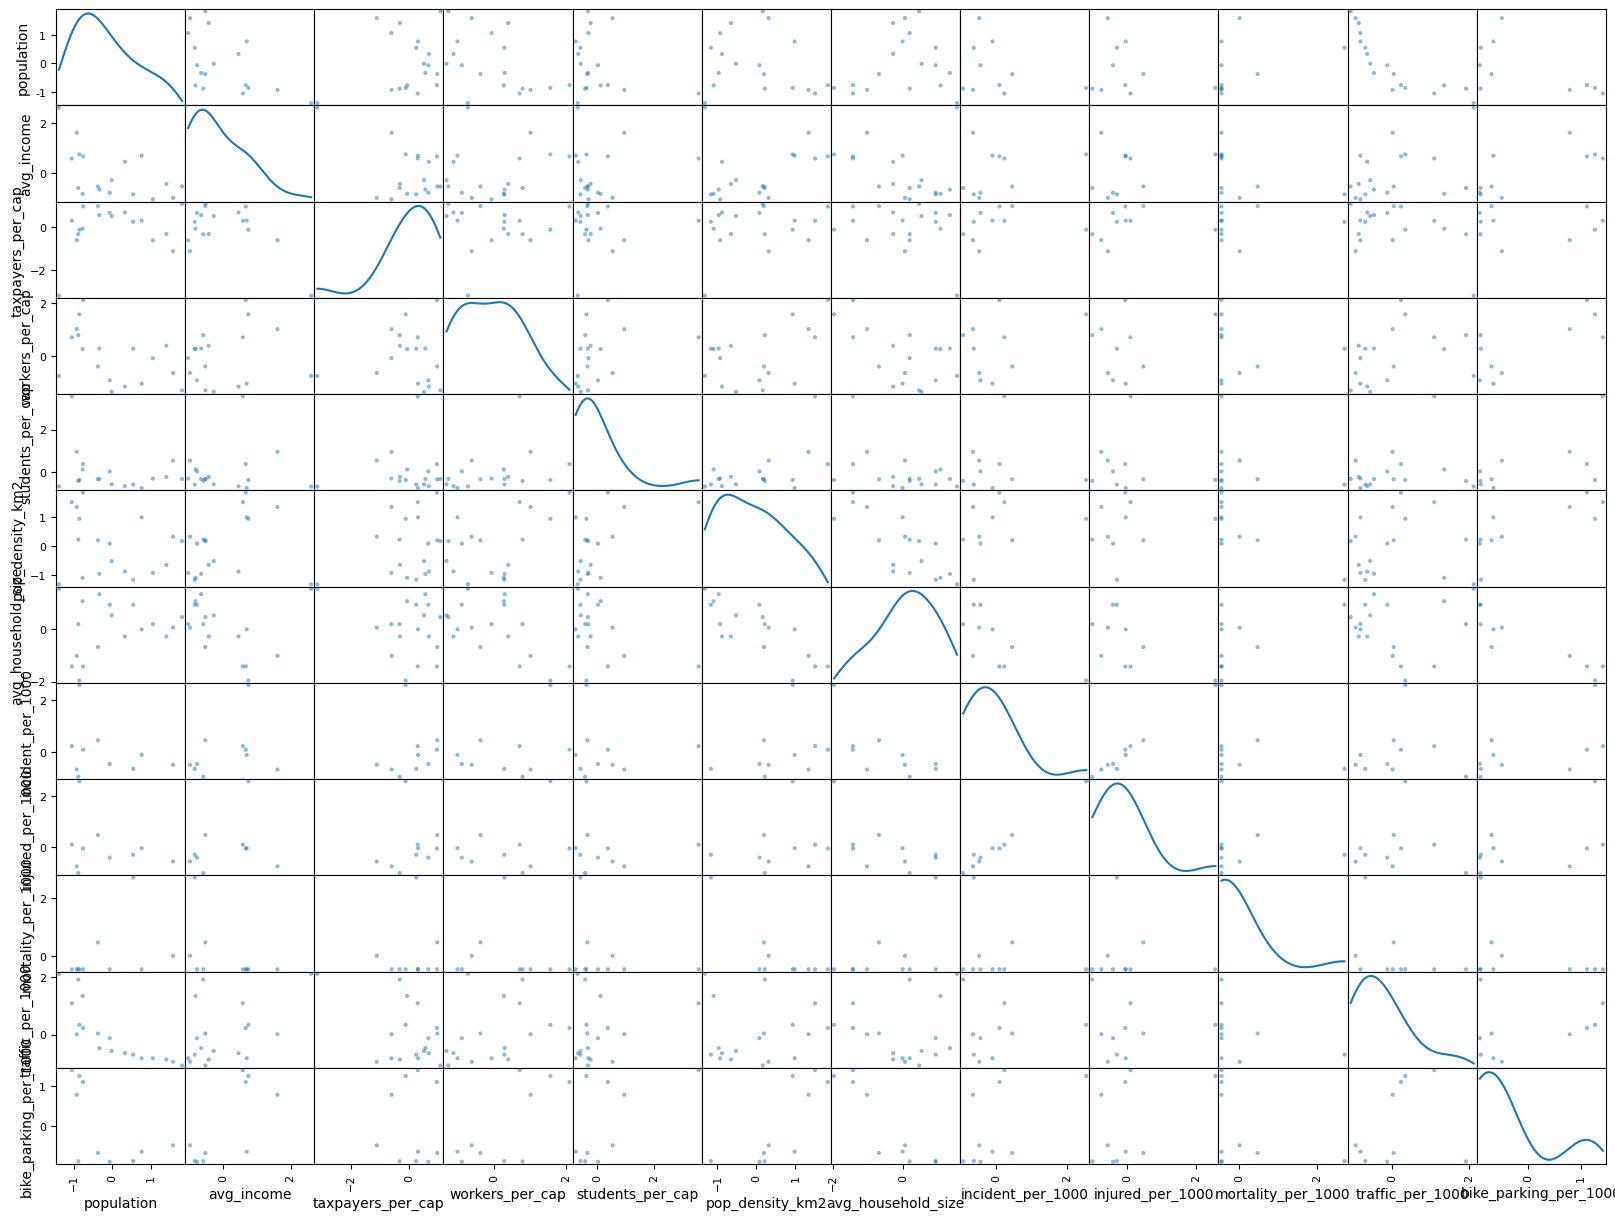

population  avg_income  taxpayers_per_cap  workers_per_cap  \
zona                                                                          
BARCA             -0.070613   -0.771083           0.665384        -0.896260   
BOLOGNINA          1.589811   -0.974448          -1.113593        -0.622311   
BORGO PANIGALE     0.544757   -0.836625           0.249519         0.286257   
COLLI             -1.402014    2.609549          -3.165192        -0.729920   
CORTICELLA        -0.342409   -0.646740           0.563728         0.295323   
COSTA SARAGOZZA    0.326821    0.459150           0.683866        -1.129216   
GALVANI           -0.938016    1.612225          -0.600693         1.016264   
IRNERIO           -0.868302    0.751004          -0.115518         1.568894   
LAME              -0.782300   -0.812961          -0.064690         0.272067   
MALPIGHI          -1.064847    0.587509           0.300347         0.711569   
MARCONI           -0.769813    0.673989           0.961110         2.101026   
MAZZINI            1.826859   -0.519672           1.081248        -1.271907   
MURRI              0.767363    0.701812           0.309588        -1.018848   
SAFFI             -0.380958   -0.522971           0.974972        -0.379106   
SAN DONATO         1.061963   -1.031242          -0.609935        -0.068104   
SAN RUFFILLO      -0.019142   -0.273425           0.517521        -1.324332   
SAN VITALE         1.416613   -0.422149          -0.314209         0.395443   
SANTA VIOLA       -0.895775   -0.583923          -0.323450         0.793162   

                 students_per_cap  pop_density_km2  avg_household_size  \
zona                                                                     
BARCA                    0.029845         0.078260            0.919319   
BOLOGNINA                0.541568         0.314051            0.048385   
BORGO PANIGALE          -0.587621        -1.165596            0.919319   
COLLI                   -0.681091        -1.321078            1.522273   
CORTICELLA              -0.327039        -0.964824            1.321288   
COSTA SARAGOZZA         -0.663152        -0.882647           -0.286589   
GALVANI                  0.952269         1.336123           -1.023533   
IRNERIO                 -0.375190         0.929676           -1.961462   
LAME                     0.121427        -1.097194            1.053309   
MALPIGHI                 3.563756         1.500944           -1.425503   
MARCONI                  0.376344         1.829417           -1.425503   
MAZZINI                 -0.324207         0.162538            0.450355   
MURRI                   -0.753790         0.979168           -0.018610   
SAFFI                   -0.340257         0.191019           -0.688559   
SAN DONATO              -0.306268        -0.928404            0.182375   
SAN RUFFILLO            -0.578180        -0.522891            0.517350   
SAN VITALE              -0.228849        -0.652459           -0.286589   
SANTA VIOLA             -0.419565         0.213898            0.182375   

                 incident_per_1000  injured_per_1000  mortality_per_1000  \
zona                                                                       
BARCA                    -0.455776         -0.412002           -0.455498   
BOLOGNINA                -0.488069         -0.563304            0.009987   
BORGO PANIGALE           -0.643725         -0.299860            2.706415   
COLLI                          NaN               NaN                 NaN   
CORTICELLA                     NaN               NaN                 NaN   
COSTA SARAGOZZA                NaN               NaN                 NaN   
GALVANI                  -0.668611         -0.752034           -0.455498   
IRNERIO                   2.554309          2.567720           -0.455498   
LAME                           NaN               NaN                 NaN   
MALPIGHI                  0.225035          0.096618           -0.455498   
MARCONI                   0.086562         

In [759]:
# MULTI VARIABLE ANALYSIS #
    # create dataframe of variables to analyze together
df_analysis = transport_2019[['population', 'avg_income', 'taxpayers_per_cap',
       'workers_per_cap', 'students_per_cap', 'pop_density_km2',
       'avg_household_size',
       'incident_per_1000', 'injured_per_1000', 'mortality_per_1000', 'traffic_per_1000', 
       'bike_parking_per_1000']]
    # calculate the z-score to give a more standard frame of rereference across metrics
df_z = (df_analysis - df_analysis.mean())/df_analysis.std()

    # display matrix of correlation
    # interesting to note : seems like population size and bike parking seem to be the most singularly explantory variables of thise selected ?
pd.plotting.scatter_matrix(df_z.loc[:, 'population':'bike_parking_per_1000'], diagonal="kde",figsize=(20,15))
plt.show()

df_z